# GovTech TAP VICA Tech Assessment (Insurance Analysis)

In [51]:
from pprint import pprint

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import preprocessing

## EDA and Data Cleaning

### Load dataset

In [39]:
df_raw = pd.read_csv("./insurance_data.csv", sep=";")
df_raw.head(3)

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
0,1,F,0.0,Yes,Yes,23,Yes,No,No,NaN,12.0,Yes,"19,65","451,55",Y
1,2,F,1.0,No,No,42,Yes,Yes,Class A,3,1.0,Yes,"84,65","3541,35",N
2,3,F,0.0,Yes,No,72,Yes,No,No,NaN,12.0,No,"19,4","1496,45",Y


**Thinking process** <br>

At a first look at the data we have, I found that "insuree#" column is just insuree id and is not relevant to our analysis or modelling. We can drop this column.

In [40]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   insuree#                  5500 non-null   int64  
 1   gender                    5387 non-null   object 
 2   is45OrOlder               5404 non-null   float64
 3   isMarried                 5500 non-null   object 
 4   hasKids                   5500 non-null   object 
 5   insuredMonths             5500 non-null   int64  
 6   termLifeInsurance         5500 non-null   object 
 7   multipleTermLifePolicies  5500 non-null   object 
 8   healthInsurance           5500 non-null   object 
 9   healthRiders              3518 non-null   object 
 10  premiumFrequency          5386 non-null   float64
 11  eStatements               5500 non-null   object 
 12  monthlyPremium            5500 non-null   object 
 13  totalPremium              5500 non-null   object 
 14  renewal 

**Thinking process** <br>

- We can see that there are missing values for variables "gender", "is45OrOlder", "premiumFrequency" and "healthRiders"
- For variable "healthRiders", rows with missing value indicates that an insuree does not have any riders on his health insurance policy
- Given little domain knowledge about insurance industry and no extra context/information given, I decide to drop rows with missing values for variables "gender", "is45OrOlder" and "premiumFrequency" instead of filling with values (such as mean/median or 0 value) to prevent adding inaccurate information and noise to the data

### Drop irrelavant columns and rows with missing values

In [41]:
# Drop "insuree#" column
df = df_raw.drop(["insuree#"], axis=1)

# Drop rows with missing values, except for "heathRiders" variable
df = df.dropna(subset=["gender", "is45OrOlder", "premiumFrequency"])

print(f"Number of rows dropped: {len(df_raw) - len(df)}")

df.info()

Number of rows dropped: 320
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5180 entries, 0 to 5499
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gender                    5180 non-null   object 
 1   is45OrOlder               5180 non-null   float64
 2   isMarried                 5180 non-null   object 
 3   hasKids                   5180 non-null   object 
 4   insuredMonths             5180 non-null   int64  
 5   termLifeInsurance         5180 non-null   object 
 6   multipleTermLifePolicies  5180 non-null   object 
 7   healthInsurance           5180 non-null   object 
 8   healthRiders              3309 non-null   object 
 9   premiumFrequency          5180 non-null   float64
 10  eStatements               5180 non-null   object 
 11  monthlyPremium            5180 non-null   object 
 12  totalPremium              5180 non-null   object 
 13  renewal                   5180 non-

**Thinking process** <br>

- Number of rows dropped: 320
- Variables "monthlyPremium" and "totalPremium" should be of integer data type
- For categorical variables, we can print all the unique values for each variable to have a better understanding

### Get unique values for categorical variables

In [42]:
# Look at the values for "healthRiders" variable
print(df["healthRiders"].unique())

[nan '3' '3,4' '2' '1' '2,3,4' '1,2,3,4' '2,4' '1,2,4' '1,4' '1,2' '1,2,3'
 '1,3,4' '1,3' '4' '2,3']


**Thinking process** <br>

- After checking the values for "healthRiders", it seems like there 4 kinds of health rider, can perform one hot encoding

In [43]:
# Creating lists for continuous and categorical variables 
continuous_vars = ["insuredMonths", "monthlyPremium", "totalPremium"] 
cat_vars = list(set(list(df.columns)).difference(set(continuous_vars)))

print("Unique values for categorical variables")
print(f"'variable name': [values]\n")
for var in cat_vars:
    print(f"'{var}': {list(df[var].unique())}")

Unique values for categorical variables
'variable name': [values]

'healthInsurance': ['No', 'Class A', 'Class B']
'hasKids': ['Yes', 'No']
'healthRiders': [nan, '3', '3,4', '2', '1', '2,3,4', '1,2,3,4', '2,4', '1,2,4', '1,4', '1,2', '1,2,3', '1,3,4', '1,3', '4', '2,3']
'multipleTermLifePolicies': ['No', 'Yes', 'no term life policy taken', 'term life policy not taken']
'renewal': ['Y', 'N']
'premiumFrequency': [12.0, 1.0, 3.0]
'eStatements': ['Yes', 'No']
'isMarried': ['Yes', 'No']
'termLifeInsurance': ['Yes', 'No']
'gender': ['F', 'M']
'is45OrOlder': [0.0, 1.0]


**Thinking process** <br>

- Can perform label encoding for all the variables other than "heathRiders"
- Looking at variable "multipleTermLifePolicies", the values ['no term life policy taken', 'term life policy not taken'] means "No". To replace these values before label encoding

### Label encoding
- In order to keep track which label correspond to which value, we will create a value to label ID mapping

In [44]:
# Clean up the values in "multipleTermLifePolicies" variable
df["multipleTermLifePolicies"].replace('term life policy not taken', "No", inplace=True)
df["multipleTermLifePolicies"].replace('no term life policy taken', "No", inplace=True)

In [45]:
val2id = {}

# Remove "healthRiders" variable from category list
# since we will not perform label encoding on it
cat_vars.remove("healthRiders") 

for var in cat_vars:
    if var != "healthRiders":
        le = preprocessing.LabelEncoder()
        df[var] = le.fit_transform(df[var])
        val2id[var] = dict(zip(le.classes_, le.transform(le.classes_)))

pprint(val2id)

{'eStatements': {'No': 0, 'Yes': 1},
 'gender': {'F': 0, 'M': 1},
 'hasKids': {'No': 0, 'Yes': 1},
 'healthInsurance': {'Class A': 0, 'Class B': 1, 'No': 2},
 'is45OrOlder': {0.0: 0, 1.0: 1},
 'isMarried': {'No': 0, 'Yes': 1},
 'multipleTermLifePolicies': {'No': 0, 'Yes': 1},
 'premiumFrequency': {1.0: 0, 3.0: 1, 12.0: 2},
 'renewal': {'N': 0, 'Y': 1},
 'termLifeInsurance': {'No': 0, 'Yes': 1}}


### One hot encoding

In [46]:
# Create new columns for "healthRider" categories
for i in range(1, 5):
    df[f"healthRider{i}"] = 0
    df[f"healthRider{i}"] = df[f"healthRider{i}"].astype("category")
    cat_vars.append(f"healthRider{i}")  # Update category variable list

def health_rider_onehot_encode(row):
    """
    Helper function to perform one hot encoding on "healthRiders" variable
    """
    health_rider_str = row["healthRiders"]

    if type(health_rider_str) == str:
        health_riders = health_rider_str.split(",")
        for hr in health_riders:
            row[f"healthRider{hr}"] = 1
    
    return row
      
df = df.apply(lambda x: health_rider_onehot_encode(x), axis=1)
df = df.drop(["healthRiders"], axis=1)  # Remove "healthRiders" because not needed anymore

### Convert variables to continuous data type

In [47]:
df["monthlyPremium"] = df.apply(lambda x: int(x["monthlyPremium"].replace(',', '')) if x["monthlyPremium"] != " " else 0, axis=1)
df["totalPremium"] = df.apply(lambda x: int(x["totalPremium"].replace(',', '')) if x["totalPremium"] != " " else 0, axis=1)

In [48]:
df.head()

,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal,healthRider1,healthRider2,healthRider3,healthRider4
0,0,0,1,1,23,1,0,2,2,1,1965,45155,1,0,0,0,0
1,0,1,0,0,42,1,1,0,0,1,8465,354135,0,0,0,1,0
2,0,0,1,0,72,1,0,2,2,0,194,149645,1,0,0,0,0
3,0,0,1,1,13,1,0,2,2,0,1955,2653,1,0,0,0,0
4,0,0,0,0,37,1,1,0,0,0,1003,35414,1,0,0,1,1


**Thinking process** <br>

- Everything looks good now!
- Now we can answer guiding questions 1 and 2

### **Guiding Question 1**

In [63]:
hr_cols = ["healthRider1", "healthRider2", "healthRider3", "healthRider4"]  

# Peform one hot ecoding on "healthRider" in raw dataset 
df_raw_encoded = df_raw.apply(lambda x: health_rider_onehot_encode(x), axis=1)

# Retrieve records that has health insurance
df_raw_has_health_insurance = df_raw_encoded[df_raw_encoded["healthInsurance"] != "No"]
df_has_health_insurance = df[df["healthInsurance"] != 2]

df_raw_hr_counts = df_raw_has_health_insurance[hr_cols].sum().to_frame()
df_hr_counts = df_has_health_insurance[hr_cols].sum().to_frame()

# Plot counts for each health rider
fig_raw = px.bar(
    df_raw_hr_counts, 
    labels={"index": "value", "value": "counts"}, 
    title="Health rider counts (before data cleaning)", 
    text_auto=True
)
fig_processed = px.bar(
    df_hr_counts, 
    labels={"index": "value", "value": "counts"}, 
    title="Health rider counts (after data cleaning)", 
    text_auto=True
)

fig_raw.show()
fig_processed.show()

In [71]:
avg_rider_raw = df_raw_hr_counts.sum()[0] / len(df_raw_has_health_insurance)
avg_rider_processed = df_hr_counts.sum()[0] / len(df_has_health_insurance)
print("Average number of riders health insurance customers purchase")
print(f"Before data cleaning: {avg_rider_raw}")
print(f"After data cleaning: {avg_rider_processed}")

Average number of riders health insurance customers purchase
Before data cleaning: 1.7832673036588207
After data cleaning: 1.7766246602421547


**Answer to guiding question 1**

- Average number of riders health insurance customers purchase (before data cleaning): 1.783
- Average number of riders health insurance customers purchase (after data cleaning): 1.777
- Most popular health rider (before data cleaning): healthRider4
- Most popular health rider (after data cleaning): healthRider4

### **Guiding Question 2**

In [72]:
# Retrieve records for older people that has health insurance
df_raw_has_health_insurance = df_raw_encoded[(df_raw_encoded["healthInsurance"] != "No") & (df_raw_encoded["is45OrOlder"] == 1)]
df_has_health_insurance = df[(df["healthInsurance"] != 2) & (df["is45OrOlder"] == 1)]

df_raw_hr_counts = df_raw_has_health_insurance[hr_cols].sum().to_frame()
df_hr_counts = df_has_health_insurance[hr_cols].sum().to_frame()

# Plot counts for each health rider
fig_raw = px.bar(
    df_raw_hr_counts, 
    labels={"index": "value", "value": "counts"}, 
    title="Health rider counts (before data cleaning)", 
    text_auto=True
)
fig_processed = px.bar(
    df_hr_counts, 
    labels={"index": "value", "value": "counts"}, 
    title="Health rider counts (after data cleaning)", 
    text_auto=True
)

fig_raw.show()
fig_processed.show()

**Answer to guiding question 2**

- Most popular health rider for older people (before data cleaning): healthRider4
- Most popular health rider for older people  (after data cleaning): healthRider4

### Checking for outliers

In [73]:
df[["insuredMonths", "monthlyPremium", "totalPremium"]].describe()

,insuredMonths,monthlyPremium,totalPremium
count,5180.000000,5180.000000,5180.000000
mean,34.689575,3500.200772,125279.350579
std,42.092435,3628.504646,192140.322038
min,0.000000,19.000000,0.000000
25%,9.000000,644.000000,7367.250000
50%,29.000000,1865.000000,35142.000000
75%,56.000000,7005.000000,142320.000000
max,720.000000,11875.000000,867245.000000


**Thinking process** <br>

- Standard deviation is very high for all 3 continuous variables
- Let's use bot plots to examine further

In [74]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=df["insuredMonths"], boxpoints="outliers", name="insuredMonths"), row=1, col=1)
fig.add_trace(go.Box(y=df["monthlyPremium"], boxpoints="outliers", name="monthlyPremium"), row=1, col=2)
fig.add_trace(go.Box(y=df["totalPremium"], boxpoints="outliers", name="totalPremium"), row=1, col=3)

fig.update_layout(title_text="Boxplots for continuous data")

fig.show()

**Thinking process** <br>

- We can see that there are outliers for variables "insuredMonths" and "totalPremium"
- We will remove outliers for these variables
- Outliers are the data points that fall outside of 1.5 times of the inter quartile range (Q3 - Q1) 

In [75]:
outlier_vars = ['insuredMonths', "totalPremium"]

Q1 = df[outlier_vars].quantile(0.25)
Q3 = df[outlier_vars].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[outlier_vars] < (Q1 - 1.5 * IQR)) |(df[outlier_vars] > (Q3 + 1.5 * IQR))).any(axis=1)]

**Thinking process** <br>

- Lets replot the box plots again to see the results after removing outliers

In [76]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=df["insuredMonths"], boxpoints="outliers", name="insuredMonths"), row=1, col=1)
fig.add_trace(go.Box(y=df["monthlyPremium"], boxpoints="outliers", name="monthlyPremium"), row=1, col=2)
fig.add_trace(go.Box(y=df["totalPremium"], boxpoints="outliers", name="totalPremium"), row=1, col=3)

fig.update_layout(title_text="Boxplots for continuous data")

fig.show()

**Thinking process** <br>

- Variable "insuredMonths" looks alot better now

### Correlation Analysis

In [79]:
df_corr = df.drop(["renewal"], axis=1)

corr = round(df_corr.corr(), 2)

fig = px.imshow(corr, text_auto=True)
fig.update_layout(width=1000, height=800)
fig.show()

**Thinking process** <br>

- Calculate the pearson's correlation coefficient
- Since none of the variables have correlation coeffient that is more than 0.7, we shall not remove any of these variable

## Training a prediction model

In [94]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

### Standardizing data

In [83]:
sc = StandardScaler()

df_x = df.drop(["renewal"], axis=1)
df_y = df["renewal"]

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=100)
X_train = pd.DataFrame(sc.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(sc.fit_transform(X_test), columns = X_test.columns)

### Check for unbalanced data

In [84]:
renewal_counts = df_y.value_counts().to_frame()

fig = px.bar(renewal_counts, labels={"index": "value", "value": "counts"}, title="Dependent variable counts")
fig.show()

**Thinking process** <br>

- Data is slightly imbalanced but still within acceptable range

### Model Training
- Train 3 different models, using Logistic Regression, Naives Bayes, Random Forest
- Perform cross validation during training to select model
- Will evaluate model performance using 4 different scoring metrics (accuracy, precision, recall and F1_macro)
- F1_macro is chosen due the slight imbalance of label classes

In [85]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    "Naives Bayes": GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
}

scoring = ['accuracy', 'precision', 'recall', 'f1_macro']

In [86]:
# To store each model's training performance
model_performance = []

for name, model in models_dict.items():
    cross_val_scores = cross_validate(estimator = model, X = X_train, y = y_train, scoring=scoring, cv = 5, n_jobs = -1)
    acc = round(cross_val_scores['test_accuracy'].mean() * 100, 4)
    prec = round(cross_val_scores['test_precision'].mean() * 100, 4)
    rec = round(cross_val_scores['test_recall'].mean() * 100, 4)
    f1 = round(cross_val_scores['test_f1_macro'].mean() * 100, 4)
    model_performance.append([acc, prec, rec, f1])
    print(f"{name} completed")

Logistic Regression completed
Naives Bayes completed
Random Forest completed


In [87]:
model_performances_df = pd.DataFrame(model_performance, columns=scoring, index=models_dict.keys())
model_performances_df

,accuracy,precision,recall,f1_macro
Logistic Regression,79.3785,83.8078,87.8793,74.0938
Naives Bayes,75.1130,87.8033,75.3594,72.3316
Random Forest,77.8531,82.4072,87.4002,71.9127


**Thinking process** <br>

- Random Forest model did not perform the best, lets try to do some parameter fine tuning to see if we can improve Random Forest's model performance

### Parameter Fine Tuning (Random Forest)
- We will be using sklearn's RandomSearchCV to find the best set of params for Random Forest model

In [88]:
n_estimators = list(range(100, 2000, 500))
max_features = ["sqrt", "log2"]
max_depth = [20, 50, 100, 150, 200]
min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [1, 2, 3]
bootstrap = [True, False]
criterion=['gini', 'entropy']

params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'criterion': criterion
}

In [89]:
rf_base = RandomForestClassifier()
rf_rand_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=params,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=100,
    n_jobs=-1,
    scoring="accuracy"
)
rf_rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1100; total time=  11.5s
[CV

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [20, 50, 100, 150, 200],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [100, 600, 1100, 1600]},
                   random_state=100, scoring='accuracy', verbose=2)

In [91]:
# Best parameters for Random Forest in this RandomSearchCV
rf_params = rf_rand_search.best_params_
rf_params

{'n_estimators': 1100,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 'log2',
 'max_depth': 50,
 'criterion': 'gini',
 'bootstrap': True}

**Thinking process** <br>

- Lets rerun the cross validation model training with the best random forest params to compare model performances again

In [90]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    "Naives Bayes": GaussianNB(),
    'Random Forest': RandomForestClassifier(**rf_params),
}

new_model_performance = []

for name, model in models_dict.items():
    cross_val_scores = cross_validate(estimator = model, X = X_train, y = y_train, scoring=scoring, cv = 5, n_jobs = -1)
    acc = round(cross_val_scores['test_accuracy'].mean() * 100, 4)
    prec = round(cross_val_scores['test_precision'].mean() * 100, 4)
    rec = round(cross_val_scores['test_recall'].mean() * 100, 4)
    f1 = round(cross_val_scores['test_f1_macro'].mean() * 100, 4)
    new_model_performance.append([acc, prec, rec, f1])
    print(f"{name} completed")

Logistic Regression completed
Naives Bayes completed
Random Forest completed


In [92]:
new_model_performances_df = pd.DataFrame(new_model_performance, columns=scoring, index=models_dict.keys())
new_model_performances_df

,accuracy,precision,recall,f1_macro
Logistic Regression,79.3785,83.8078,87.8793,74.0938
Naives Bayes,75.1130,87.8033,75.3594,72.3316
Random Forest,79.1243,82.8502,88.9555,73.2244


**Thinking process** <br>

- We can see that performance for Random Forest model improved, both for accuracy and F1 score
- However, the best model is still using Logistic Regression


### Testing our best model on test data set

In [95]:
best_model = LogisticRegression()
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)

acc = accuracy_score(y_test, predictions) 
precision = precision_score(y_test, predictions) 
recall = recall_score(y_test, predictions) 
f1 = f1_score(y_test, predictions, average="macro")

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.801354401805869
Precision: 0.864696734059098
Recall: 0.862015503875969
F1 Score: 0.7498588368153585


**Thinking process** <br>

- Our model is able to achieve 80% accuracy on the test set

## Feature Importance
- We will use Logistic Regression and Random Forest models to find the most important features

### Logistic Regression for feature importance

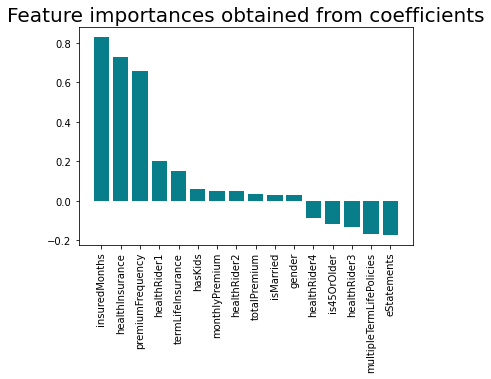

In [96]:
lr_clf = LogisticRegression().fit(X_train, y_train)

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lr_clf.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances (Logistic Regression)', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Random Forest for feature importance

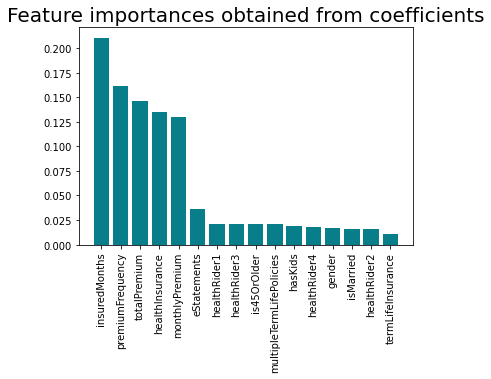

In [97]:
rf_clf = RandomForestClassifier(**rf_params)

rf_clf.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': rf_clf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances (Random Forest)', size=20)
plt.xticks(rotation='vertical')
plt.show()

### **Guiding Question 3**

- We used Logistic Regression and Random Forest to gain insights into insuree behaviours
- Reason for using these 2 models as we can calculate feature importances easily with these 2 models
- Regression and ensemble methods provide easy way to understand our model as compared to models such as deep neural network even though neural network may provide better results

### **Guiding Question 4**

- We can see that "insureMonths" variable is the most important factors from the 2 feature importance charts
- It also makes sense to predict that a person who has an long active insurance will continue to renew their insurance policies and remain insured